In [16]:
import os
from scipy.io import arff
from scipy import signal, interpolate
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import pdb
import time
import shutil

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
video_names = [
    '01_art_gallery_static.arff',
    '02_theatre_scene_static.arff',
    '03_lions_static_cuts.arff',
    '04_copenhagen_harbour_static_cuts.arff',
    '05_florida_yacht_motion.arff',
    #'06_dance_experience_static.arff',
    '07_factory_robots_static.arff',
    '08_madagascar_cuts.arff',
    '09_elephants_static.arff',
    #'10_cruise_festival_skate_cuts.arff',
    '11_lohdi_garden_india_cuts.arff',
    '12_gym_workout_static.arff',
    '13_times_square_static.arff',
    '14_new_orleans_drive_motion.arff',
    #'15_interrogation_static.arff',
    '16_interview_static.arff',
    '17_weather_forecast_static.arff',
    '18_bomb_trapped_static.arff',
    #'19_nurse_motion.arff',
    '20_car_fix_static.arff',
    '21_operation_room_static.arff',
    #'22_surgical_checklist_static.arff',
    '23_dog_food_factory_motion.arff',
    #'24_nurse_motion_challenge.arff',
    #'25_theatre_scene_static_challenge.arff',
    #'26_new_orleans_drive_motion_challenge.arff',
    #'27_times_square_static_challenge.arff',
    #'28_dance_experience_static_challenge.arff'
]

# Video heights of the 28 videos
video_heights = [
    2160,
    1920,
    1920,
    2160,
    2048,
    #2160,
    1920,
    2048,
    2048,
    #2160,
    2160,
    2048,
    1920,
    2160,
    #2048,
    2048,
    1920,
    2160,
    #2160,
    1920,
    1920,
    #2160,
    2160,
    #2160,
    #1920,
    #2160,
    #1920,
    #2160
]

video_width = 3840

In [4]:
columns = ['x', 'y', 'x_head', 'y_head', 'angle_deg_head', 'quaternion_hp_w',
        'quaternion_hp_x', 'quaternion_hp_y', 'quaternion_hp_z', 'frameId']
column_to_index = {}
for i, column in enumerate(columns):
    column_to_index[column] = i

In [15]:
input_data = None
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'datasetTUM')

delta_means = []
delta_stdevs = []

# Loop through every user from 2 to 50
for i in range(2,50+1):
    subjectId = str(i).zfill(3)
    # Loop through every video
    for j, video_name in enumerate(video_names):
        filename = subjectId + '_' + video_name
        #subjectId = "016"
        #filename = "016_13_times_square_static.arff"
        fname = os.path.join(dataset_path, subjectId, filename)
        try:
            # Load arff to structured array + metadata
            data, meta = arff.loadarff(fname)
        except:
            print("File " + filename + " does not exist.")
            continue
        
        delta_t = (data["time"][1:] - data["time"][0:-1]) / 1000
        mean_delta_t = np.mean(delta_t)
        std_delta_t = np.std(delta_t)
        delta_means.append(mean_delta_t)
        delta_stdevs.append(std_delta_t)
print("Mean:", np.mean(delta_means))
print("Standard deviation:", np.mean(delta_stdevs))

File 018_04_copenhagen_harbour_static_cuts.arff does not exist.
File 038_17_weather_forecast_static.arff does not exist.
Mean: 8.749548611075818
Standard deviation: 2.878849597973839


In [35]:
# Loop through every user from 2 to 50

count_closed_eyes = 0
for i in range(2,5+1):
    subjectId = str(i).zfill(3)
    # Loop through every video
    for j, video_name in enumerate(video_names):
        filename = subjectId + '_' + video_name
        #subjectId = "016"
        #filename = "016_13_times_square_static.arff"
        fname = os.path.join(dataset_path, subjectId, filename)
        try:
            # Load arff to structured array + metadata
            data, meta = arff.loadarff(fname)
        except:
            print("File " + filename + " does not exist.")
            continue

        # Deal with closed eyes in the beginning or end of video sequence
        if data['confidence'][0] == 0:
            count_closed_eyes += 1
            print("User closed eyes! (" + str(count_closed_eyes) + ")")
            continue
        
        final_index = len(data) - 1
        while data['confidence'][final_index] != 1:
            final_index -= 1

        initial_index = 0
        while data['confidence'][initial_index] != 1:
            initial_index += 1
           
        data = data[initial_index:final_index+1]
        
        data_temp = data.copy()
        outlier_threshold = 500
        
        def is_outlier(x1, x2, x3, threshold):
            return (abs(x1 - x2) >= threshold
                    and abs(x2 - x3) >= threshold
                    and abs(x1 - x3) <= threshold)
        
        for column in ['x', 'y', 'x_head', 'y_head']:
            for k in range(len(data)-2):
                if is_outlier(data[column][k], data[column][k+1], data[column][k+2], outlier_threshold):
                    #print("catched")
                    data_temp[column][k+1] = (data[column][k] + data[column][k+2]) / 2
        
        data = data_temp
        delta_t = 10000
        t_new = np.arange(data['time'][0], data['time'][-1], delta_t)
        
        input_data_video = np.zeros((len(t_new), len(columns)))
        for j, column in enumerate(columns):
            if column in ['x', 'y']:
                index_confidence_0 = (data['confidence'] == 0)
                data_filtered = data[np.logical_not(index_confidence_0)]
            else:
                data_filtered = data
            
            #if column in ['x', 'y', 'x_head', 'y_head']:
            #    kernel_size = 2+1
            #    data_filtered[column] = signal.medfilt(data_filtered[column], kernel_size)
            
            #if column != 'frameId':
            f = interpolate.interp1d(data_filtered['time'], data_filtered[column])
            input_data_video[:, j] = f(t_new)

User closed eyes! (1)
User closed eyes! (2)
User closed eyes! (3)
User closed eyes! (4)
User closed eyes! (5)


(5973, 10)


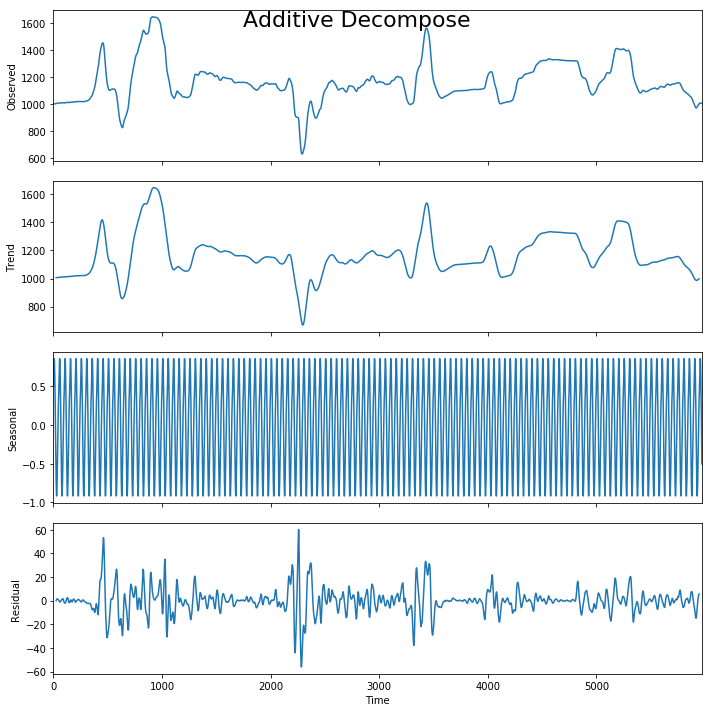

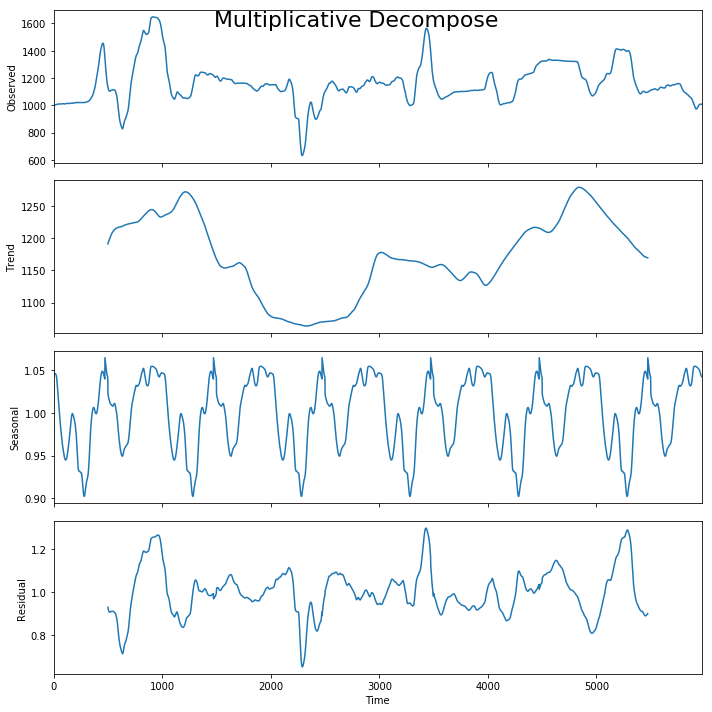

In [52]:
# Additive Decomposition
print(input_data_video.shape)
result_add = seasonal_decompose(input_data_video[:,3], model='additive', freq=50)
# Multiplicative Decomposition 
result_mul = seasonal_decompose(input_data_video[:,3], model='multiplicative', freq=1000)
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)

result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.show()